In [ ]:
import pandas as pd
dataset=pd.read_csv("/content/drive/MyDrive/Time series/stock_data.csv")
dataset.head(3)


,index,DATE,TRADINGCODE,LTP*,HIGH,LOW,OPENP*,CLOSEP*,YCP,TRADE,VALUE(mn),VOLUME
0,0,2020-12-01,1JANATAMF,6.1,6.3,6.1,6.2,6.1,6.2,304,9.311,"1,503,031"
1,1,2020-11-30,1JANATAMF,6.2,6.5,6.1,6.5,6.2,6.4,539,16.332,"2,617,333"
2,2,2020-11-29,1JANATAMF,6.4,6.7,6.3,6.5,6.4,6.5,453,19.140,"2,953,085"


In [ ]:
dataset.isnull().sum()

,0
index,0
DATE,0
TRADINGCODE,0
LTP*,0
HIGH,0
LOW,0
OPENP*,0
CLOSEP*,0
YCP,0
TRADE,1


Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - loss: 0.0704 - mae: 0.1892 - val_loss: 0.0405 - val_mae: 0.1853
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 0.0113 - mae: 0.0823 - val_loss: 0.0322 - val_mae: 0.1667
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 0.0081 - mae: 0.0697 - val_loss: 0.0156 - val_mae: 0.1151
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - loss: 0.0066 - mae: 0.0618 - val_loss: 0.0076 - val_mae: 0.0777
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.0058 - mae: 0.0581 - val_loss: 0.0040 - val_mae: 0.0513
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.0052 - mae: 0.0546 - val_loss: 0.0052 - val_mae: 0.0617
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 0.0052 - mae: 0.0533 - val_loss: 0.0038 - val_mae: 0.0511
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 115ms/step - loss: 0.0043 - mae: 0.0493 - val_loss: 0.0029 - val_mae: 0.0439
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms

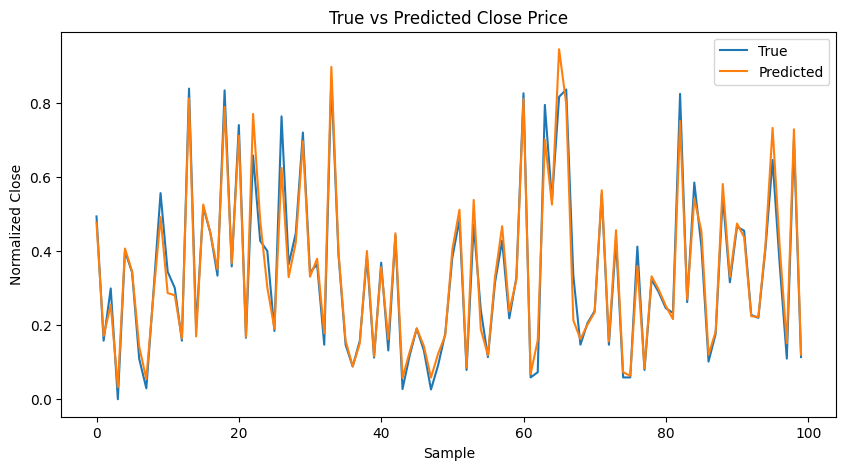

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, Add, BatchNormalization, Dropout, LSTM, MultiHeadAttention, LayerNormalization, Conv1DTranspose
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


df = pd.read_csv("/content/drive/MyDrive/Time series/stock_data.csv")


if 'VALUE' in df.columns:
    df = df.drop(columns=['VALUE'])

# 3. Clean numeric columns (remove commas, convert to float)
numeric_cols = ['OPENP*', 'HIGH', 'LOW', 'CLOSEP*', 'VOLUME']
for col in numeric_cols:
    df[col] = df[col].replace({',': ''}, regex=True)
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Convert invalid strings to NaN


df['VOLUME'] = df['VOLUME'].fillna(df['VOLUME'].median())


df['DATE'] = pd.to_datetime(df['DATE'])


SEQ_LEN = 30
FEATURES = ['OPENP*', 'HIGH', 'LOW', 'CLOSEP*', 'VOLUME']
TARGET = 'CLOSEP*'


def create_sequences(df, seq_len=30):
    X, y = [], []
    for scrip, group in df.groupby("TRADINGCODE"):
        group = group.sort_values("DATE")
        values = group[FEATURES].values
        if len(values) <= seq_len:
            continue
        scaler = MinMaxScaler()
        values_scaled = scaler.fit_transform(values)
        for i in range(len(values_scaled) - seq_len):
            X.append(values_scaled[i:i+seq_len])
            y.append(values_scaled[i+seq_len][FEATURES.index(TARGET)])
    return np.array(X), np.array(y).reshape(-1, 1)

X_all, y_all = create_sequences(df, seq_len=SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# 8. Residual CNN Block
def residual_cnn_block(inputs):
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    shortcut = Conv1D(filters=64, kernel_size=1, padding="same")(inputs)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    return x

# 9. Transformer Block
def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn = Dropout(dropout)(attn)
    out1 = Add()([attn, inputs])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn = Dense(ff_dim, activation='relu')(out1)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([ffn, out1])
    return LayerNormalization(epsilon=1e-6)(out2)

# 10. Build Hybrid Model
def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = residual_cnn_block(inputs)
    x = transformer_block(x)
    x = LSTM(64)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])
    return model

# 11. Train Model
model = build_model(X_train.shape[1:])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)

# 12. Predictions
y_pred = model.predict(X_test)

# 13. Evaluation Metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Directional Accuracy
direction_true = np.sign(y_test[1:] - y_test[:-1])
direction_pred = np.sign(y_pred[1:] - y_pred[:-1])
directional_accuracy = np.mean(direction_true == direction_pred) * 100

print(f"\n--- Evaluation Metrics ---")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

# 14. Plot
plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="True")
plt.plot(y_pred[:100], label="Predicted")
plt.title("True vs Predicted Close Price")
plt.xlabel("Sample")
plt.ylabel("Normalized Close")
plt.legend()
plt.show()


In [ ]:
print(f"\n--- Evaluation Metrics ---")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")


--- Evaluation Metrics ---
MAE: 0.0302
MSE: 0.0019
RMSE: 0.0435
R² Score: 0.9643
Directional Accuracy: 94.92%


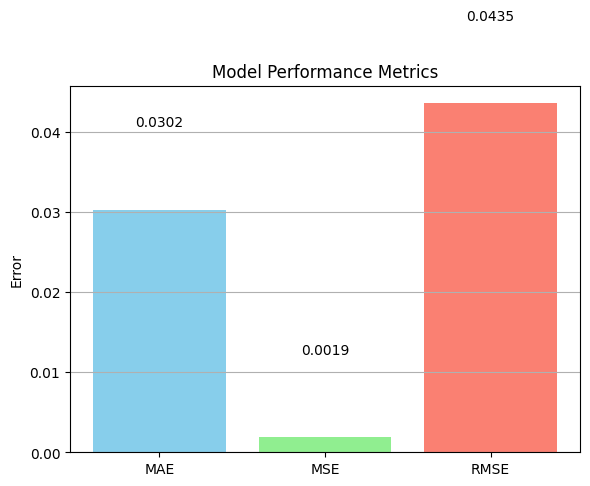

In [ ]:


import seaborn as sns

# -- A. Metric Comparison Bar Chart --
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, rmse]

plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Model Performance Metrics")
plt.ylabel("Error")
plt.grid(axis='y')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


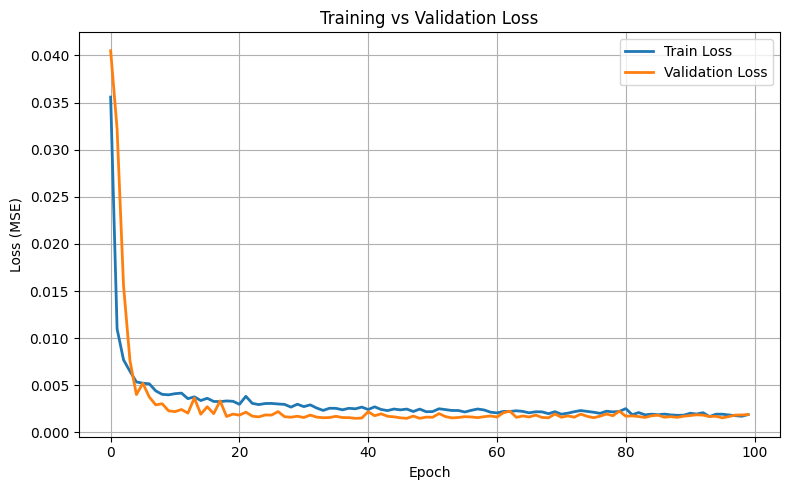

In [ ]:
# -- B. Training vs Validation Loss Curve --
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

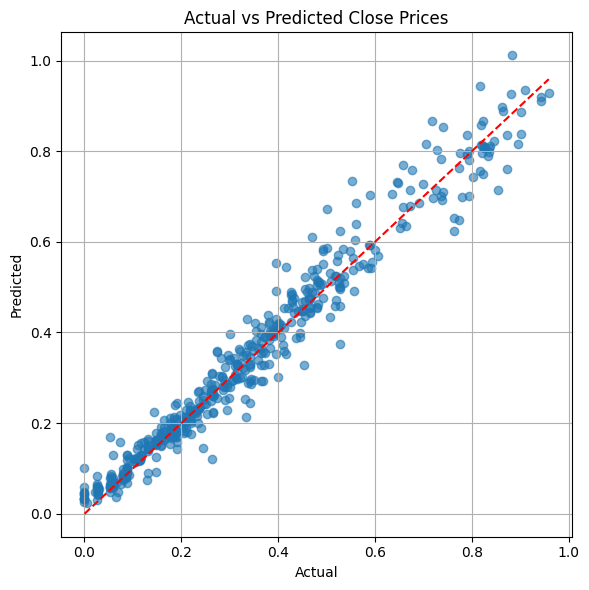

In [ ]:
# -- C. Scatter Plot: Actual vs Predicted --
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

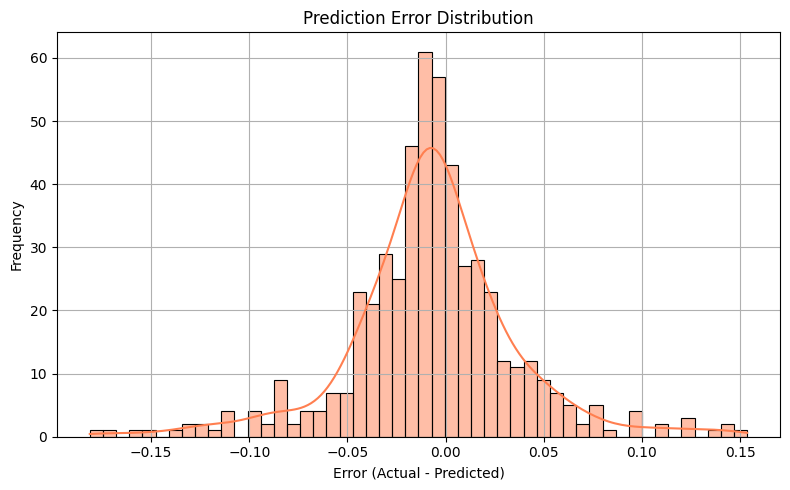

In [ ]:
# -- D. Error Histogram --
errors = y_test.flatten() - y_pred.flatten()
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True, color='coral')
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()